### Setup only needs to be done once

In [ ]:
using Pkg
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("LinearAlgebra")
Pkg.add("Random")
Pkg.add("Statistics")
Pkg.add("PyPlot")
Pkg.add("LsqFit")

In [2]:
using DataFrames
using CSV
using LinearAlgebra
using Random
using Statistics
using PyPlot
using LsqFit

In [3]:
df = DataFrame(CSV.File("Conway's GOL - Histogram of # Generations.csv"))
generations = df.generations
num_patterns = df.num_patterns;

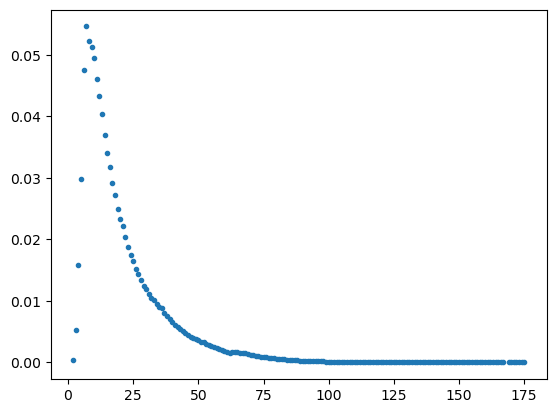

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x35feccda0>

In [4]:
ens_size = sum(num_patterns)
normalized_data = num_patterns./ens_size
plot(generations, normalized_data, ".")

After failing to be able to sucessfully fit this profile to any typical distributions (I primarily tried a poisson distribution), a few things occurred to me about this plot. Firstly, the first five data points are almost linear, and then the remaining data points all appear to be exponentially decaying. This becomes even more obvious if we plot the log of the data:

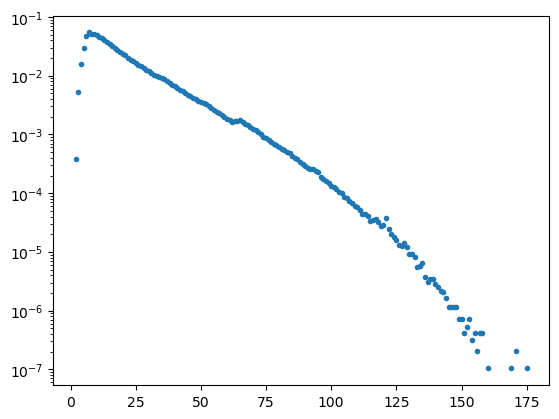

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x33b909ac0>

In [5]:
semilogy(generations, normalized_data, ".")

When plotting the log, exponential curves become straight lines, which (while not perfect) most of the data on the right looks roughly like a line. So I made the decision to throw out the first 5 data points. There's probably some deeper insight about why there's a linear increase followed by exponential decay going on, but ultimately I am trying to estimate the statistical upper bound so throwing away a few data points at small values is worth it if it makes the fit much nicer:

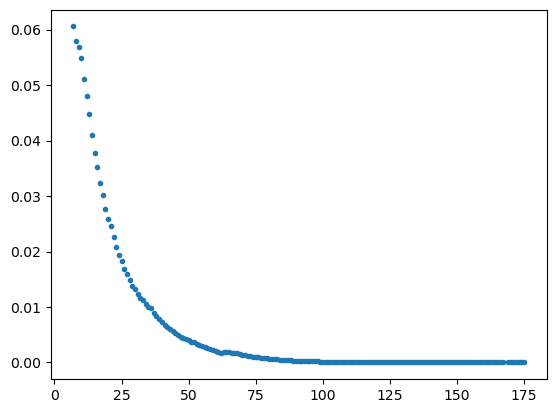

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x33bc22150>

In [6]:
smaller_data = num_patterns[6:end]
smaller_gens = generations[6:end]

normalized_small_data = smaller_data./sum(smaller_data)
plot(smaller_gens, normalized_small_data, ".")

Now I just fit the data to an exponential model of the form $Ae^{-Bx}$:

In [7]:
@. model(x, p) = p[1]*exp(-p[2]*x)

residual(x, p) = normalized_small_data .- model(x, p)

result = curve_fit(residual, smaller_gens, zeros(length(normalized_small_data)), [1.0, 1.0])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.10199560849474533, 0.06676828929428033], [-0.003342366620665442, -0.0018317386553351606, 0.0009429560352490762, 0.0025725651736975344, 0.0021939254402238983, 0.0021891642951901297, 0.0019087925767231825, 0.0009214256726220726, 0.00037313452402093494, 0.00012470366757644236  …  -1.6751744411259585e-6, -1.5669781422920473e-6, -1.465770034534815e-6, -1.1678145627829705e-6, -1.1997051968718041e-6, -8.927634106595671e-7, -1.0497366033524375e-6, -9.819361328791207e-7, -9.185147645364935e-7, -7.444620943306096e-7], [-0.6266431588148547 0.4474039521807762; -0.5861694810835683 0.4782937034212113; … ; -9.005434430878362e-6 0.00015982159860116686; -8.423790722084854e-6 0.00015035821873443534], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [8]:
result.param

2-element Vector{Float64}:
 0.10199560849474533
 0.06676828929428033

So the fit gives a model of $0.102 e^{-0.0668 x}$. Checking the error on the parameters:

In [9]:
stderror(result)

2-element Vector{Float64}:
 0.0006728998371419805
 0.00041560373699612137

So the fit has a pretty low error. Plotting the fit:

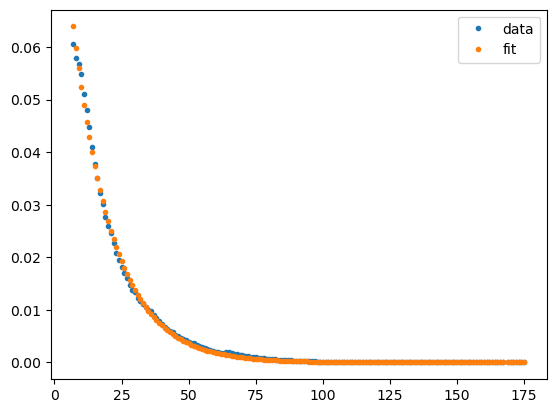

PyObject <matplotlib.legend.Legend object at 0x33bbab320>

In [10]:
plot(smaller_gens, normalized_small_data, ".", label = "data")
plot(smaller_gens, model(smaller_gens, result.param), ".", label = "fit")
legend()

So we just then need to calculate where the value of this probabilty becomes equal to $\frac{1}{2^{64}}$, which in this case gives 630:

In [11]:
log(1.0/(2.0^64*(result.param[1])))/(-(result.param[2])) 

630.2182440196704

The $\pm 4$ number I gave you earlier basicaly comes from the fact that tweaking the above parameters by their standard error causes the number to adjust up or down by about 4.

One thing to note in particular, when dealing with exponentials the fits can sometimes look a lot better than they actually are, if we plot the log of the data and the fit we see that it does seem to overestimate on the higher end of things:

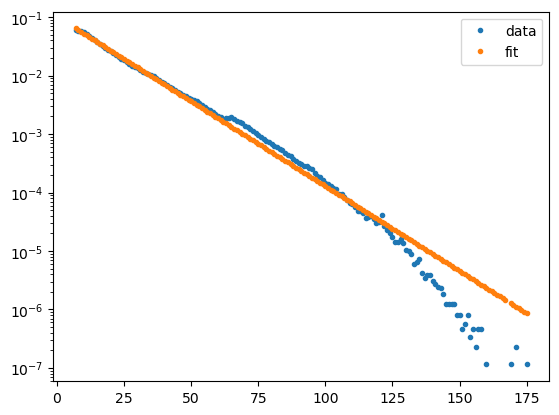

PyObject <matplotlib.legend.Legend object at 0x35fef8f20>

In [12]:
semilogy(smaller_gens, normalized_small_data, ".", label = "data")
semilogy(smaller_gens, model(smaller_gens, result.param), ".", label = "fit")
legend()

So it looks like the probability of the actual data starts dropping off for the higher values, this could jsut be due to the fact that there is very little data at that point, causing the fit to be off for those values. With an even larger sample size we could see moreso what the data does at the higher end of things. Other things that could be done would be to try different models, maybe ones that aren't completely linear on a log plot, and try and fit the slight curvature we see here. Either way, given what this fit looks like, 630 is *probably* not gonna be the answer, but it at least provides an estimate for the upper bound on what the answer is likely to be. But who knows, maybe there's some crazy statistical outlier which is much larger than that.